In [0]:
# 먼저 로밍등록자 추세에 대해 1D Convolution에 의한 regression으로 입국자를 추정한다.
# 이후, news를 doc2vec으로 vector화 하여 Convolution에 의한 regression으로 입국자를 추정한다.
# 마지막으로 두개의 feature group을 합친 알고리즘에 의해 입국자를 추정한다.
# 로밍등록자 정보는 과거 추세를 잘 설명할 것이나, 예측력은 떨어질 듯...
# news에 의한 추정은 과거 추세 설명력도 떨어지고 예측력도 로밍등록자 Case보다는 떨어지겠지만 미래 예측적인 측면에서는 일반적인 시계열 추정보다는 좋을 듯...

In [2]:
!nvidia-smi

Sat May  2 06:21:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#공개된 Roaming Dataset을 읽고, 중간 중간 나온것을 합친다.
rm1 = pd.read_csv("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0406/Roaming_data.csv",encoding="utf-8")
rm2 = pd.read_csv("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0429/Roaming_data.csv",encoding="utf-8")
rm = pd.concat([rm1, rm2], ignore_index=True, sort=False)

# 합친 Dataset의 내용 확인
rm

,return,iso,arrival,departure,count
0,20200131,ad,20200130,20200130,3
1,20200131,ae,20191231,20200125,3
2,20200131,ae,20191231,20200131,3
3,20200131,ae,20200102,20200102,3
4,20200131,ae,20200104,20200131,3
...,...,...,...,...,...
217800,20200401,vn,20200330,20200401,3
217801,20200401,vn,20200331,20200331,20
217802,20200401,vn,20200331,20200401,6
217803,20200401,vn,20200401,20200401,45


In [4]:
#도착일을 기준으로 입국자(로밍등록자)를 합산한다.
ar = pd.DataFrame(rm.groupby('arrival')['count'].sum())
ar['date'] =  ar.index.astype('object')
#date column을 datetime 으로 casting 한다.
ar['date'] =  pd.to_datetime(ar['date'], format='%Y%m%d')

# 날자별 입국자(로밍등록자) 정리 dataset 확인
ar

,count,date
arrival,,
20191031,91,2019-10-31
20191101,36,2019-11-01
20191102,120,2019-11-02
20191103,159,2019-11-03
20191104,179,2019-11-04
...,...,...
20200424,711,2020-04-24
20200425,463,2020-04-25
20200426,447,2020-04-26


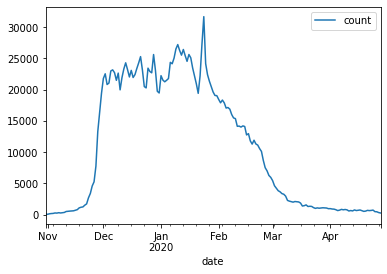

In [5]:
# 입국자(로밍등록자) 추세 chart 확인
ar.plot(x='date',y='count')

In [6]:
# iso 별로 재배열
ar_iso = pd.DataFrame(rm.groupby(['arrival','iso'])['count'].sum())
rows = []
date = None
r = None
for row in ar_iso.iterrows():
  if date == row[0][0]:
    pass
  else:
    if not r is None:
      rows.append(r)
    r = {}

  r['arrival'] = row[0][0]
  r[row[0][1]] = row[1][0]
  date = row[0][0]
rows.append(r)
ds_iso = pd.DataFrame(rows)
ds_iso.fillna(0, inplace=True)
ds_iso = ds_iso.set_index('arrival')
ds_iso['total'] = ar['count']
ds_iso.index =  ds_iso.index.astype('object')
#index을 datetime 으로 casting 한다.
ds_iso.index =  pd.to_datetime(ds_iso.index, format='%Y%m%d')
ds_iso

,ae,at,cn,de,hk,jp,kh,kw,la,mm,my,no,pe,ph,pl,th,us,vn,hu,ma,mn,au,ch,fr,gb,in,iq,lk,qa,sg,uz,cz,dk,es,fi,id,nz,ru,sa,sk,...,tp,vu,zw,rs,tk,ug,bz,bo,cy,na,pg,rw,bt,lr,mz,pr,tg,mk,an,cv,tt,md,ad,ga,gn,re,ky,bf,bj,cf,tc,ls,td,mr,to,ws,gm,ye,ml,total
arrival,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-31,3.0,3.0,20,3.0,6.0,6,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,8,12.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91
2019-11-01,0.0,0.0,6,3.0,0.0,3,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,9,0.0,0.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36
2019-11-02,0.0,0.0,26,6.0,3.0,9,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,6,19.0,3.0,0.0,0.0,0.0,6.0,3.0,6.0,3.0,6.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120
2019-11-03,3.0,3.0,30,0.0,12.0,14,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,3.0,13,21.0,6.0,3.0,0.0,0.0,0.0,3.0,0.0,6.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,3.0,3.0,9.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,159
2019-11-04,12.0,3.0,40,3.0,3.0,10,0.0,0.0,0.0,0.0,6.0,0.0,0.0,6.0,0.0,6,24.0,9.0,3.0,0.0,0.0,3.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,6.0,6.0,3.0,0.0,0.0,3.0,3.0,0.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-24,0.0,12.0,84,34.0,19.0,157,0.0,0.0,0.0,3.0,3.0,0.0,0.0,30.0,0.0,18,62.0,44.0,6.0,0.0,3.0,3.0,0.0,9.0,12.0,6.0,0.0,0.0,0.0,6.0,6.0,0.0,6.0,3.0,0.0,28.0,0.0,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,711
2020-04-25,0.0,9.0,39,15.0,4.0,111,21.0,0.0,0.0,6.0,3.0,0.0,0.0,6.0,0.0,6,73.0,27.0,0.0,0.0,3.0,0.0,0.0,0.0,6.0,3.0,0.0,0.0,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,463
2020-04-26,0.0,0.0,42,14.0,10.0,98,6.0,0.0,0.0,0.0,3.0,0.0,0.0,12.0,0.0,3,50.0,40.0,3.0,0.0,0.0,0.0,0.0,3.0,6.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,27.0,0.0,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,447


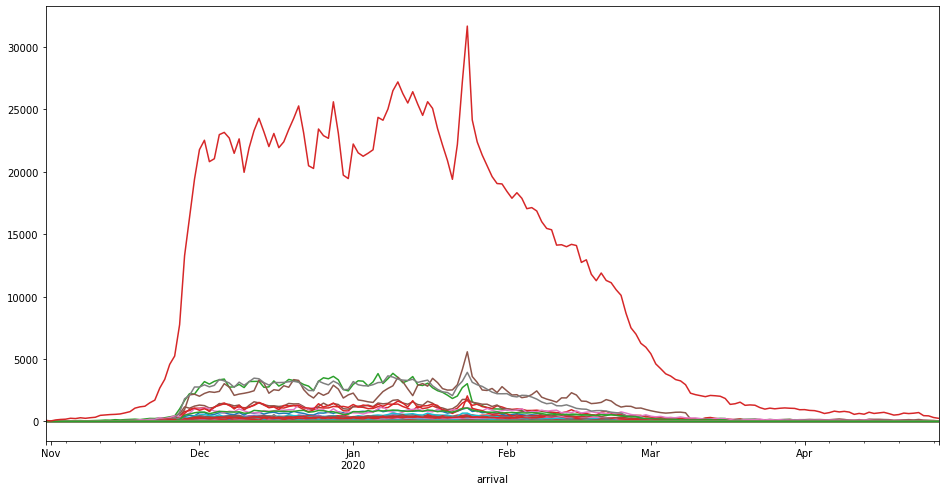

In [7]:
ds_iso.plot(legend=False,figsize=(16,8))

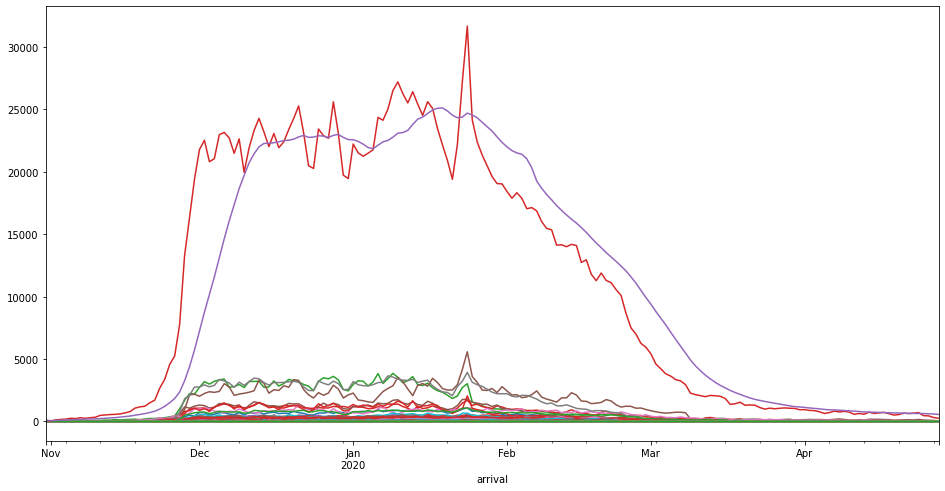

In [8]:
# 2주 (14일) 평균 추세 추가.
raw_ds = ds_iso.copy()
raw_ds['arrival_14ma'] = raw_ds['total'].rolling(window=14, min_periods=0).mean()
raw_ds.plot(legend=False,figsize=(16,8))

In [0]:
import numpy as np

# Time-series CNN을 적용하기 위한 전처리
# 1D Convolution을 적용하기 위해..
# window를 30일로 설정 -> 그냥 잡은 수치
window = 30
#입력 feature 개수.
size = len(raw_ds.columns) - 1 # totoal column 제외
#향후 15일 예측
forecast_days = 15


train_org_y = raw_ds['total'].to_numpy()
data = (raw_ds.drop(columns=['total'])).to_numpy()

train_x = []
train_y = []

for i in range(data.shape[0]-window-forecast_days + 1):
    sub_x = []
    for j in range(window):
        sub_x.append(data[i+j,:])
    train_x.append(sub_x)

    sub_y = []
    for z in range(forecast_days):
        sub_y.append(train_org_y[i + window + z])
    train_y.append(sub_y)

#train_x ,train_y의 준비
train_x = np.asarray(train_x)
train_x = train_x.reshape(-1,window,size)
train_y = np.asarray(train_y)

test_x = data[data.shape[0]-window:data.shape[0],:]

In [10]:
#train_x ,train_y의 내용 확인.
train_x, train_x.shape, train_y, train_y.shape, test_x, test_x.shape

(array([[[3.00000000e+00, 3.00000000e+00, 2.00000000e+01, ...,
          0.00000000e+00, 0.00000000e+00, 9.10000000e+01],
         [0.00000000e+00, 0.00000000e+00, 6.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 6.35000000e+01],
         [0.00000000e+00, 0.00000000e+00, 2.60000000e+01, ...,
          0.00000000e+00, 0.00000000e+00, 8.23333333e+01],
         ...,
         [7.20000000e+01, 1.21000000e+02, 1.00200000e+03, ...,
          0.00000000e+00, 0.00000000e+00, 2.35085714e+03],
         [1.20000000e+02, 1.44000000e+02, 1.68200000e+03, ...,
          0.00000000e+00, 0.00000000e+00, 3.25900000e+03],
         [1.41000000e+02, 1.56000000e+02, 2.22900000e+03, ...,
          0.00000000e+00, 0.00000000e+00, 4.38428571e+03]],
 
        [[0.00000000e+00, 0.00000000e+00, 6.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 6.35000000e+01],
         [0.00000000e+00, 0.00000000e+00, 2.60000000e+01, ...,
          0.00000000e+00, 0.00000000e+00, 8.23333333e+01],
       

In [11]:
# model 생성...
# 이게 최적의 layer 구성인지는 모름... 일반적/직관적으로 layer 설정 
import keras
from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D
from keras.models import Sequential

model = Sequential()
model.add(Conv1D(128,4, input_shape=(window, size),padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(64, 4,padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(32, 4,padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(256))
model.add(Dense(forecast_days))
model.add(Activation('linear'))

model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),metrics=['mae'])

model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 30, 128)           89216     
_________________________________________________________________
activation_1 (Activation)    (None, 30, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 15, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 15, 64)            32832     
_________________________________________________________________
activation_2 (Activation)    (None, 15, 64)            0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 64)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 7, 32)            

In [12]:
#학습 시작...
hist = model.fit(train_x, train_y, epochs=800,verbose=1)

Epoch 1/800
137/137 [==============================] - 6s 46ms/step - loss: 232721665.0511 - mae: 11856.7129
Epoch 2/800
137/137 [==============================] - 0s 172us/step - loss: 103138583.2409 - mae: 7938.6104
Epoch 3/800
137/137 [==============================] - 0s 171us/step - loss: 73343165.1679 - mae: 6934.5566
Epoch 4/800
137/137 [==============================] - 0s 182us/step - loss: 62021925.8394 - mae: 5919.8091
Epoch 5/800
137/137 [==============================] - 0s 171us/step - loss: 41671987.0219 - mae: 4969.0737
Epoch 6/800
137/137 [==============================] - 0s 179us/step - loss: 30172007.7372 - mae: 3765.8577
Epoch 7/800
137/137 [==============================] - 0s 202us/step - loss: 19715556.5766 - mae: 3094.5447
Epoch 8/800
137/137 [==============================] - 0s 194us/step - loss: 13249885.8175 - mae: 2374.9148
Epoch 9/800
137/137 [==============================] - 0s 205us/step - loss: 12475699.7226 - mae: 2419.7148
Epoch 10/800
137/137 [====

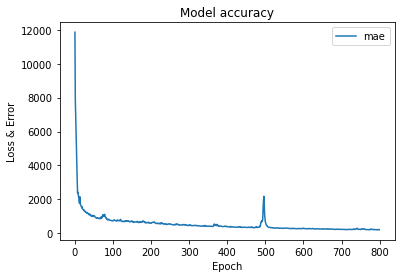

In [13]:
# 학습에 대한 accuracy 확인.
#plt.plot(np.asarray(hist.history['loss'])/1000)
plt.plot(hist.history['mae'])
plt.title('Model accuracy')
plt.ylabel('Loss & Error')
plt.xlabel('Epoch')
plt.legend(['mae'], loc='upper right')
plt.show()

In [14]:
# 모델에 의한 예측 입국자 count를 과거 Dataset에 적용
predit_y = model.predict(train_x)
predit_y,predit_y.shape

(array([[19329.428  , 21683.83   , 22231.2    , ..., 23126.07   ,
         24080.428  , 23165.32   ],
        [21514.45   , 22534.854  , 20640.596  , ..., 23935.822  ,
         23040.342  , 21966.734  ],
        [22416.268  , 20736.387  , 20855.498  , ..., 22872.062  ,
         22187.438  , 22734.578  ],
        ...,
        [  694.10504,   607.9602 ,   602.96606, ...,   558.9707 ,
           545.8307 ,   485.2936 ],
        [  683.5449 ,   611.6129 ,   617.74945, ...,   473.27744,
           469.50198,   431.31366],
        [  674.75134,   588.422  ,   596.4503 , ...,   451.49466,
           450.20383,   427.5248 ]], dtype=float32), (137, 15))

In [15]:
# window와 forecast_days에 의해 실제 날자와 차이나는 부분의 보정 처리...
predit = []
for forecast in range(forecast_days):
  predit.append(list(np.concatenate((np.zeros(window+ forecast), predit_y[:,forecast],np.zeros(forecast_days-forecast-1)), axis=0)))

a = pd.DataFrame(predit)
a

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19329.427734,21514.449219,22416.267578,20700.171875,20866.056641,22874.474609,22728.132812,22709.080078,21641.089844,22013.509766,...,1329.090210,1252.101318,1126.174927,1060.385376,1060.516724,1113.076538,1085.803467,1089.604370,1114.275024,1033.312378,1019.123718,953.590393,977.902832,912.112122,799.883240,761.021423,750.340393,727.859924,741.302429,734.951233,731.437988,736.161560,718.908630,694.105042,683.544922,674.751343,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,21683.830078,22534.853516,20736.386719,21380.876953,23028.398438,23274.013672,22555.435547,21868.908203,22439.751953,...,1301.523193,1255.219971,1227.327881,1112.038574,1073.324097,1020.250916,1026.332031,1020.322144,1043.740723,1062.422852,989.750488,1052.227661,976.046936,863.459473,795.643066,712.275085,704.513916,691.851135,677.502380,650.825684,622.798889,654.032471,668.338318,640.685669,607.960205,611.612915,588.421997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,22231.199219,20640.595703,20855.498047,22347.287109,22792.408203,22308.755859,21817.000000,20990.373047,...,1365.427246,1292.405273,1207.979980,1171.070557,1064.906738,1027.126221,1003.570374,1018.726501,1022.442566,1000.453735,949.124451,898.810852,946.292847,937.985962,873.266602,839.577454,764.538879,731.191956,701.314758,703.867737,687.293396,680.309387,696.991272,668.718628,640.469788,602.966064,617.749451,596.450317,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,20611.111328,21025.544922,23044.853516,22977.957031,22602.832031,21641.425781,21977.527344,...,1324.391357,1310.591797,1295.693359,1273.663818,1175.451660,1089.020020,1051.880005,1039.426270,1060.409424,1066.864014,1072.341797,1006.115540,930.096069,887.563293,828.209473,816.525024,800.620850,745.713867,717.037292,716.427124,728.338989,744.987244,721.946533,732.424561,687.688049,679.096069,651.587158,636.506592,623.993408,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,20964.501953,23054.814453,23172.072266,22197.603516,21850.671875,22133.638672,...,1357.330566,1327.387695,1217.255005,1255.520264,1177.545654,1081.981812,1074.902710,1022.069885,969.361877,989.625916,1014.714050,1063.057983,1031.071411,928.550171,919.697754,786.695801,774.694580,786.630798,796.360168,776.772583,738.781128,729.476868,754.821777,709.232666,741.239014,719.279236,728.860840,690.721558,677.004761,652.625488,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,22882.167969,22960.015625,22386.349609,21939.203125,21941.351562,...,1486.590088,1348.758057,1226.354736,1105.479248,1089.763550,1073.380371,1026.476807,1055.297852,991.217468,970.837

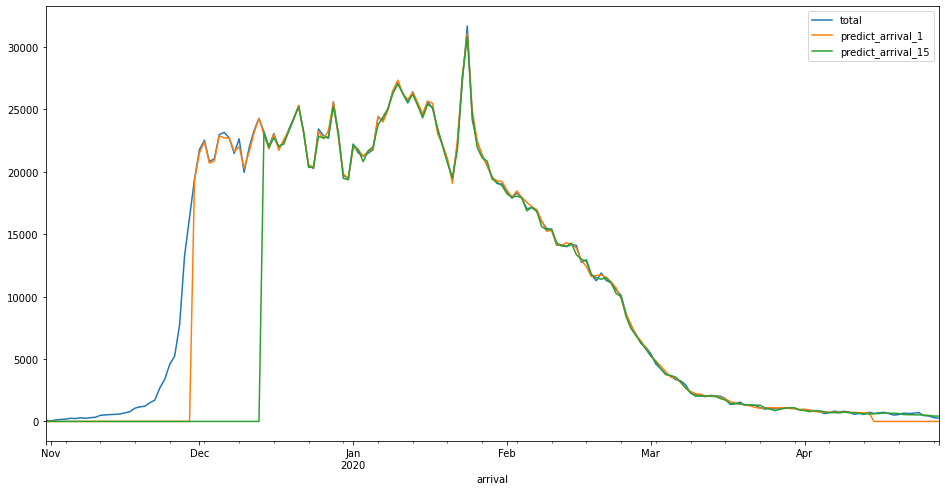

In [16]:
# 예측치를 chart에 같이 그려서 확인
comp_ds = raw_ds.copy()
comp_ds['predict_arrival_1'] = predit[0]
comp_ds['predict_arrival_15'] = predit[14]
comp_ds.plot(y=['total','predict_arrival_1','predict_arrival_15'],figsize=(16,8))
# 예측치가 overfit 되어 보이기도...

In [17]:
#1일 후인 2020-04-29에서, 15일후 5-12까지의 예측
# 마지막 30일치 정보를 input으로...

test_x = test_x.reshape(-1,window,size)
predit_y = model.predict(test_x)
predit_y.shape

(1, 15)

In [18]:
predic_ds = []
# 로밍등록자는 실 입국자의 약 24%에 해당되므로.. 이를 보정 처리 한다.
predit_y1 = predit_y * 100/24
from datetime import datetime, timedelta
last_date = raw_ds.index[-1]
print('============================================================')
for predict_count in predit_y1[0]:
  last_date += timedelta(days=1)
  print('Forecast of the number of immigrants on ' +str(last_date)[10]+ ':',int(predict_count))
  predic_ds.append({'date':last_date,'forecast':int(predict_count)})
print('============================================================')

predic_ds = pd.DataFrame(predic_ds)
predic_ds

Forecast of the number of immigrants on  : 1627
Forecast of the number of immigrants on  : 1667
Forecast of the number of immigrants on  : 1694
Forecast of the number of immigrants on  : 1711
Forecast of the number of immigrants on  : 1714
Forecast of the number of immigrants on  : 1601
Forecast of the number of immigrants on  : 1413
Forecast of the number of immigrants on  : 1339
Forecast of the number of immigrants on  : 1339
Forecast of the number of immigrants on  : 1415
Forecast of the number of immigrants on  : 1403
Forecast of the number of immigrants on  : 1318
Forecast of the number of immigrants on  : 1187
Forecast of the number of immigrants on  : 1110
Forecast of the number of immigrants on  : 1176


,date,forecast
0,2020-04-29,1627
1,2020-04-30,1667
2,2020-05-01,1694
3,2020-05-02,1711
4,2020-05-03,1714
5,2020-05-04,1601
6,2020-05-05,1413
7,2020-05-06,1339
8,2020-05-07,1339
9,2020-05-08,1415


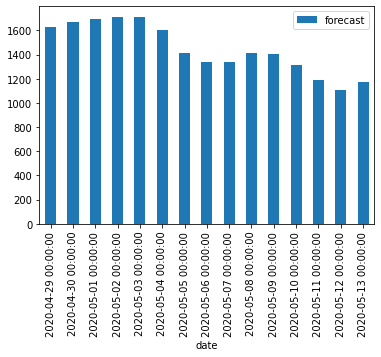

In [19]:
predic_ds.plot(x='date',y='forecast',kind='bar')

In [0]:
# corona 관련 news가 입국자에 어떻게 영향을 주었는지 분석하기 위해서는 news의 내용을 알아야 하고 labeling 의 과정이
# 사람에 의해 이루어 져야 하나, 그럴 공수는 들이지 못하므로, doc2vec을 활용하여 news를 vector화 하고 이를 입국자수에 대해 regression한다.
# news vector는 하루의 최대 뉴스수를 기준으로 2d metric를 만든다.
# EDA과정에 의해 corona로 분류된 뉴스는 하루 최대 1948, 이며 document의 vector 사이즈는 임으로 40을 정했다. 
# 자원의 활용상 news의 title만 vector화 하였다. 만약, contents 를 vector화 한다면 vector sizr를 400~1000으로 충분히 크게 잡으면 될 것이고,
# 전체적인 과정 및 알고리즘은 동일하다.

# 즉, 전체 분석 알고리즘은 
# 분석대상 날자수 (=로밍데이터와 동일한 날자수) ~ 181, 따라서 전체 metric은 (181,1948,40) 
# 이것을 시계열로 학습해서 예측을 하기 위해서는 로밍등록자 예측과 유사하게 30일 window로 15일을 예측하도록 한다.
# 따라서 학습셋(train_news_x)의 최종 shape은 (136,1948,40,30) 이될것.. train_news_y 는 (136,15)...
# train_news_x (136,1948,40,30) -> convolutional regression to train_news_y (136,15)


In [0]:
# 뉴스 기사 정보를 읽어서... 나뉘어 있는 Dataset을 합친다.
ns1 = pd.read_excel("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0406/NewsList.xls")
ns2 = pd.read_excel("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0429/NewsList.xls")
ns =pd.concat([ns1, ns2], ignore_index=True, sort=False)

In [23]:
ns

,파일명,제목,URL,수집일자,게시일자,채널명,감염병명,분류명
0,AFRO2019120200003,WHO supports Angola’s Government efforts to en...,https://www.afro.who.int/news/who-supports-ang...,2019-12-02 21:00:16.0,2019-12-02 00:00:00,AFRO,Poliomyelitis,Viral
1,AFRO2019120300001,African First Ladies laud progress against HIV...,https://www.afro.who.int/news/african-first-la...,2019-12-03 00:00:17.0,2019-12-02 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
2,AFRO2019120300002,Eritrea Observed World AIDS Day 2019,https://www.afro.who.int/news/eritrea-observed...,2019-12-03 00:00:18.0,2019-12-02 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
3,AFRO2019120400003,West and Central Africa Expands Access to HIV ...,https://www.afro.who.int/news/west-and-central...,2019-12-04 03:00:14.0,2019-12-03 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
4,AFRO2019120400004,Nearly 23 million voluntary male medical circu...,https://www.afro.who.int/news/nearly-23-millio...,2019-12-04 22:00:14.0,2019-12-04 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
...,...,...,...,...,...,...,...,...
103822,XWFB2020040900020,"Ching Ming remembrance, home country forever! ...",http://wsjkw.sh.gov.cn/xwfb/20200404/2f54e0e14...,2020-04-09 16:05:21.0,2020-04-04 00:00:00,Shanghai Municioal Health Commission,COVID-19,Viral
103823,ZWYW2020041000002,Guangdong Provincial Health Commission notifie...,http://wsjkw.gd.gov.cn/zwyw_yqxx/content/post_...,2020-04-10 18:00:45.0,2020-04-10 00:00:00,Health Commission of Guangdong Province,Dengue fever,Viral
103824,ZWYW2020041500002,Guangdong Provincial Health Commission announc...,http://wsjkw.gd.gov.cn/zwyw_yqxx/content/post_...,2020-04-15 23:01:04.0,2020-04-15 00:00:00,Health Commission of Guangdong Province,Influenza,Viral
103825,ZWYW2020041500003,Guangdong Provincial Health Commission release...,http://wsjkw.gd.gov.cn/zwyw_yqxx/content/post_...,2020-04-15 23:01:13.0,2020-04-15 00:00:00,Health Commission of Guangdong Province,Influenza,Viral


In [24]:
cov_news = ns.loc[ns['감염병명'] == 'COVID-19']
cov_news['게시일자'] =  cov_news['게시일자'].str[:10]
cov_buz = pd.DataFrame(cov_news.groupby('게시일자')['감염병명'].count())
cov_buz = cov_buz.loc[cov_buz.index >= '2019-10-31']
cov_buz['date'] = pd.to_datetime(cov_buz.index, format='%Y-%m-%d')
cov_buz = cov_buz.rename(columns={"감염병명":"buz_count"})
cov_buz

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,buz_count,date
게시일자,,
2019-12-01,1,2019-12-01
2019-12-14,2,2019-12-14
2019-12-30,3,2019-12-30
2019-12-31,5,2019-12-31
2020-01-02,1,2020-01-02
...,...,...
2020-04-26,1176,2020-04-26
2020-04-27,1353,2020-04-27
2020-04-28,999,2020-04-28


In [25]:
max_buz_per_day = cov_buz['buz_count'].max()
max_buz_per_day

1948

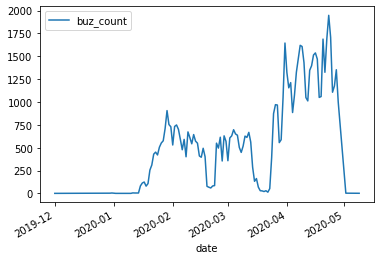

In [26]:
cov_buz.plot(x='date',y='buz_count')

In [27]:
!pip install nltk
#Import all the dependencies
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [28]:
#ns2 = cov_news.head(10)
tagged_data = []
for row in cov_news.iterrows():
    file_name = row[1][0]
    title = str(row[1][1])
    pub_datetime = row[1][4]
    tagged_data.append(TaggedDocument(words=word_tokenize(title.lower()), tags=[file_name]))
    
len(tagged_data)

73752

In [30]:
max_epochs = 10 # 이건 나중에 100 정도로 수정...
vec_size = 40
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")

print("Model Saved")

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


iteration 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Model Saved


In [31]:
# doc2vec 모델 학습 결과 확인..
from gensim.models.doc2vec import Doc2Vec

model= Doc2Vec.load("d2v.model")

# to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
print(model.docvecs['AFRO2020013100001'])

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


[ 0.6442611  -0.53671753  1.2004722  -0.5717443   0.5683985  -0.1764215
 -1.019586    0.91261685  0.7194078   0.09687414 -0.48264655 -0.31238866
 -0.15888818 -0.5280081  -0.8786781   1.5205582   0.5434704  -0.39503998
  0.91762304  1.8859266  -0.257847   -0.8021391  -0.50667876 -0.46430254
 -1.3436102   0.39511138  0.17286897 -1.29504     0.10404196 -0.87494266
  0.8843639   0.31994936 -0.66550803 -0.35284173 -0.6671661  -0.94385856
 -0.672377   -0.81298226  0.8602634  -0.9028348 ]


In [33]:
# doc2vec을 feature로 하는 학습셋을 구성한다.
# 이때, 입국일자을 기준으로 셋을 만드는데...
# 입국일에 news가 없을 때도 있어서, 일관성 있는 양질의 학습셋이 되기는 어려울 듯...
# 준대로 해야지 어쩔 수 없음.

cov_news['게시일자'] = pd.to_datetime(cov_news['게시일자'], format='%Y-%m-%d')
news_metric = []
from datetime import datetime, timedelta
import numpy as np
# 날짜별 (1948,40) 구성
for row in ar.iterrows():
    date = row[1][1]#datetime(2019,12,31)
    selected_ns = cov_news.loc[cov_news['게시일자'] >= date].loc[cov_news['게시일자'] < (date + timedelta(days=1))]
    #print(date,selected_ns.shape)
    if selected_ns.shape[0] == 0:
        # news가 없는 경우..
        news_metric.append(np.zeros((max_buz_per_day,vec_size)))
    else:
        docv = []
        for nrow in selected_ns.iterrows():
            #print('tag name:',nrow[1][0])
            docv.append(model.docvecs[nrow[1][0]])
        for i in range(max_buz_per_day-selected_ns.shape[0]):
            docv.append(np.zeros(vec_size))
        news_metric.append(docv)
        
train_x = np.asarray(news_metric)
train_x.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(181, 1948, 40)

In [34]:
# 학습셋의 내용 확인...
train_x[162]

array([[-0.48562202,  0.35702035, -0.17731094, ...,  0.05509437,
         0.23173918, -0.81407869],
       [-0.2632381 ,  0.09800957,  0.61995232, ..., -0.10052709,
         0.20762978, -0.39154336],
       [-0.15411419, -0.49098772,  0.73880398, ...,  0.38423163,
         0.24065116, -0.4661943 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [35]:
# 학습셋의 label... train_y의 구성
train_y = ar['count']
train_y.shape
                                   

(181,)